# Unsupervised Learning

[Andrew Wheeler, PhD](mailto:andrew.wheeler@hms.com)

This uses deidentified claims data from New York ([SPARCS-2009](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/q6hk-esrj)) to estimate unsupervised clusters of health claims data. Using [OPTICS hierarchical clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html).

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt
import os 
import sys

# Adding in HMS plotstyle
sys.path.append(r'C:\Users\e009156\Documents\GitHub\data-science-utils\plt')
import hms_plotstyle

# Reading in Data and Prepping it
os.chdir(r'C:\Users\e009156\Documents\GitHub\data-science-utils\education\Intro_DataScience\DimensionReduction_UnsupervisedLearning')
sparc = pd.read_csv('SparcSample.csv')
# To make it simpler, lets only look at surgical procedures (still over 100k observations)
sparc = sparc[sparc['Surgical'] == 1].copy()
sparc.drop(columns=['Surgical','APRSevere'], inplace=True)
sparc.describe().T

,count,mean,std,min,25%,50%,75%,max
APRDRG,155430.0,335.181104,189.412420,1.000000,175.0000,302.000000,512.000000,952.000000
AgeBin,155430.0,54.090620,20.357301,10.000000,40.0000,60.000000,80.000000,80.000000
LenOfStay,155430.0,6.017275,9.593985,1.000000,2.0000,3.000000,6.000000,120.000000
MedicareMedicaid,155430.0,0.398051,0.489498,0.000000,0.0000,0.000000,1.000000,1.000000
LogCharges,155430.0,4.474219,0.408140,0.778151,4.1928,4.446529,4.726112,6.612332
AdmissEmergency,155430.0,0.865026,0.932242,0.000000,0.0000,0.000000,2.000000,2.000000


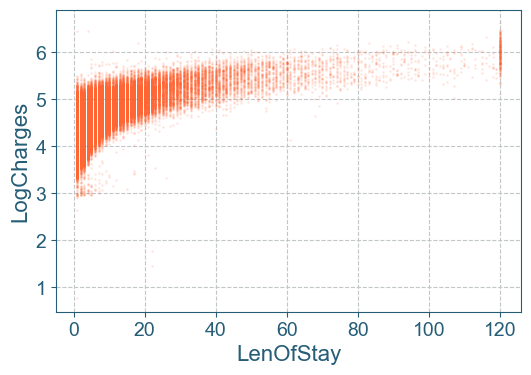

In [2]:
ax = sparc.plot.scatter(x='LenOfStay', y='LogCharges', s=1, alpha=0.1)

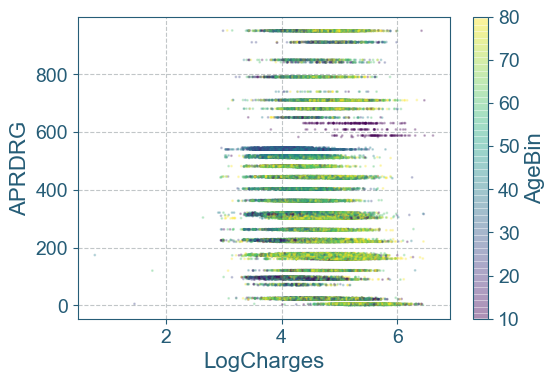

In [3]:
# Annoying error
import warnings
warnings.filterwarnings("ignore")

# Error with cutting off X axis when using color and pandas plotting
fig, ax = plt.subplots()
ax = sparc.plot.scatter(x='LogCharges', y='APRDRG', c='AgeBin', 
                        colormap='viridis', ax=ax, s=1, alpha=0.25)

# 600 codes are neonate
# See https://www.health.ny.gov/facilities/hospital/reimbursement/apr-drg/weights/2018-07-01_final_weights.htm

In [4]:
# MinMax scaling each column to 0/1
scaler = MinMaxScaler()
sparcS = sparc.sample(20000, random_state=10) #10k is 13 seconds, 20k is not quite a minute
scaler.fit(sparcS)
sparc_scaled = pd.DataFrame(scaler.transform(sparcS),columns=list(sparcS))

# OPTICS hierarchical clustering, takes a few minutes!
from datetime import datetime
print(datetime.now()) #to show how long it takes
clustering = OPTICS(min_samples=200, max_eps=3) #min samples means a cluster has to have at least 500 
                                                #claims, max_eps is the max Euclidean distance
clustering.fit(sparc_scaled)
print(datetime.now())

# Adding labels back into dataset
sparcS['ClusterLabel'] = clustering.labels_
sparcS['ClusterLabel'].value_counts() #-1 means it is an outlier, in no cluster

2021-04-28 12:16:06.532727
2021-04-28 12:16:34.444145


-1     9613
 5     2665
 1     1838
 4     1334
 9     1191
 2     1082
 3      501
 6      431
 0      425
 7      418
 8      269
 10     233
Name: ClusterLabel, dtype: int64

In [5]:
# Now lets aggregate the characteristics for each cluster
aggG = sparcS.groupby('ClusterLabel').mean()
aggG.sort_values(by='LogCharges', ascending=False, inplace=True)
aggG

,APRDRG,AgeBin,LenOfStay,MedicareMedicaid,LogCharges,AdmissEmergency
ClusterLabel,,,,,,
0,204.992941,80.000000,6.432941,1.00000,4.621469,1.000000
9,229.214945,60.000000,6.042821,0.00000,4.593270,2.000000
7,211.674641,60.000000,4.626794,0.00000,4.586308,1.000000
6,269.638051,80.000000,4.211137,0.00000,4.530215,0.000000
1,269.360174,80.000000,4.300871,1.00000,4.522712,0.000000
2,278.124769,60.000000,4.265250,1.00000,4.519124,0.000000
-1,342.671487,48.371476,8.039218,0.47675,4.515160,1.379278
5,315.526079,60.000000,3.499062,0.00000,4.478188,0.000000
8,529.078067,40.000000,3.598513,0.00000,4.167527,1.000000


In [6]:
# Lets check out top two groups and bottom two groups
gp = aggG.index.to_list()
sparcS[sparcS['ClusterLabel'] == gp[0]]

,APRDRG,AgeBin,LenOfStay,MedicareMedicaid,LogCharges,AdmissEmergency,ClusterLabel
322830,20,80,14,1,5.003663,1,0
150586,221,80,9,1,4.846931,1,0
476449,161,80,5,1,5.077445,1,0
635426,301,80,5,1,4.374224,1,0
88548,175,80,2,1,4.462500,1,0
...,...,...,...,...,...,...,...
651790,165,80,12,1,4.882123,1,0
504540,161,80,1,1,5.161348,1,0
586223,305,80,17,1,4.611939,1,0
130964,173,80,16,1,4.796859,1,0


In [7]:
sparcS[sparcS['ClusterLabel'] == gp[1]]

,APRDRG,AgeBin,LenOfStay,MedicareMedicaid,LogCharges,AdmissEmergency,ClusterLabel
494957,301,60,5,0,4.666099,2,9
271241,315,60,2,0,3.944177,2,9
585678,173,60,3,0,4.176600,2,9
179496,21,60,7,0,4.881813,2,9
146349,225,60,1,0,4.271493,2,9
...,...,...,...,...,...,...,...
102437,166,60,14,0,5.104138,2,9
629317,23,60,15,0,5.101387,2,9
594368,301,60,7,0,4.389662,2,9
648997,263,60,2,0,4.264017,2,9


In [8]:
sparcS[sparcS['ClusterLabel'] == gp[-1]] #540 is C-section

,APRDRG,AgeBin,LenOfStay,MedicareMedicaid,LogCharges,AdmissEmergency,ClusterLabel
639062,540,25,4,0,4.055509,2,10
295062,540,25,3,0,4.003383,2,10
257231,540,25,6,0,4.281826,2,10
248836,540,25,3,0,3.953037,2,10
441031,540,25,3,0,3.964303,2,10
...,...,...,...,...,...,...,...
372893,540,25,3,0,4.212135,2,10
573714,540,25,4,0,4.018169,2,10
433393,540,25,3,0,3.949146,2,10
348790,540,25,4,0,3.988648,2,10


In [9]:
sparcS[sparcS['ClusterLabel'] == gp[-2]]

,APRDRG,AgeBin,LenOfStay,MedicareMedicaid,LogCharges,AdmissEmergency,ClusterLabel
21051,540,25,5,0,4.136403,0,3
589533,541,25,2,0,3.552222,0,3
320559,540,25,5,0,4.275103,0,3
479998,540,25,3,0,3.917740,0,3
286577,540,25,3,0,4.243110,0,3
...,...,...,...,...,...,...,...
343466,540,25,3,0,3.680703,0,3
186028,540,25,3,0,4.630657,0,3
618867,540,25,4,0,4.258841,0,3
454260,540,25,4,0,4.291141,0,3
